In [ ]:
! pip install qucumber

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from qucumber.nn_states import ComplexWaveFunction

from qucumber.callbacks import MetricEvaluator

import qucumber.utils.unitaries as unitaries
import qucumber.utils.cplx as cplx

import qucumber.utils.training_statistics as ts
import qucumber.utils.data as data
import qucumber

In [ ]:
train_path = "qubits_train.txt"
train_bases_path = "qubits_train_bases.txt"
psi_path = "qubits_psi.txt"
bases_path = "qubits_bases.txt"

train_samples, true_psi, train_bases, bases = data.load_data(
    train_path, psi_path, train_bases_path, bases_path
)

In [ ]:
unitary_dict = unitaries.create_dict()
# unitary_dict = unitaries.create_dict(<unitary_name>=torch.tensor([[real part],
#                                                                   [imaginary part]],
#                                                                  dtype=torch.double)

In [ ]:

nv = train_samples.shape[-1]
nh = nv

nn_state = ComplexWaveFunction(
    num_visible=nv, num_hidden=nh, unitary_dict=unitary_dict, gpu=False
)

In [ ]:
epochs = 500
pbs = 100  # pos_batch_size
nbs = pbs  # neg_batch_size
lr = 0.1
k = 10

In [ ]:

def alpha(nn_state, space, **kwargs):
    rbm_psi = nn_state.psi(space)
    normalization = nn_state.normalization(space).sqrt_()
    alpha_ = cplx.norm(
        torch.tensor([rbm_psi[0][0], rbm_psi[1][0]], device=nn_state.device)
        / normalization
    )

    return alpha_


def beta(nn_state, space, **kwargs):
    rbm_psi = nn_state.psi(space)
    normalization = nn_state.normalization(space).sqrt_()
    beta_ = cplx.norm(
        torch.tensor([rbm_psi[0][1], rbm_psi[1][1]], device=nn_state.device)
        / normalization
    )

    return beta_


def gamma(nn_state, space, **kwargs):
    rbm_psi = nn_state.psi(space)
    normalization = nn_state.normalization(space).sqrt_()
    gamma_ = cplx.norm(
        torch.tensor([rbm_psi[0][2], rbm_psi[1][2]], device=nn_state.device)
        / normalization
    )

    return gamma_


def delta(nn_state, space, **kwargs):
    rbm_psi = nn_state.psi(space)
    normalization = nn_state.normalization(space).sqrt_()
    delta_ = cplx.norm(
        torch.tensor([rbm_psi[0][3], rbm_psi[1][3]], device=nn_state.device)
        / normalization
    )

    return delta_

In [ ]:

period = 25
space = nn_state.generate_hilbert_space()

callbacks = [
    MetricEvaluator(
        period,
        {
            "Fidelity": ts.fidelity,
            "KL": ts.KL,
            "normα": alpha,
            # "normβ": beta,
            # "normγ": gamma,
            # "normδ": delta,
        },
        target=true_psi,
        bases=bases,
        verbose=True,
        space=space,
    )
]

In [ ]:
nn_state.fit(
    train_samples,
    epochs=epochs,
    pos_batch_size=pbs,
    neg_batch_size=nbs,
    lr=lr,
    k=k,
    input_bases=train_bases,
    callbacks=callbacks,
    time=True,
)

Epoch: 25	Fidelity = 0.738674	KL = 0.148394	normα = 0.242037
Epoch: 50	Fidelity = 0.951741	KL = 0.025630	normα = 0.271605
Epoch: 75	Fidelity = 0.978811	KL = 0.014960	normα = 0.269267
Epoch: 100	Fidelity = 0.986592	KL = 0.011239	normα = 0.268264
Epoch: 125	Fidelity = 0.987753	KL = 0.010987	normα = 0.269122
Epoch: 150	Fidelity = 0.990042	KL = 0.009163	normα = 0.263637
Epoch: 175	Fidelity = 0.990600	KL = 0.008327	normα = 0.272158
Epoch: 200	Fidelity = 0.990702	KL = 0.008235	normα = 0.269554
Epoch: 225	Fidelity = 0.991401	KL = 0.007531	normα = 0.281577
Epoch: 250	Fidelity = 0.991185	KL = 0.007693	normα = 0.263600
Epoch: 275	Fidelity = 0.991774	KL = 0.006828	normα = 0.272830
Epoch: 300	Fidelity = 0.991607	KL = 0.006966	normα = 0.271227
Epoch: 325	Fidelity = 0.992302	KL = 0.006213	normα = 0.271707
Epoch: 350	Fidelity = 0.992373	KL = 0.006371	normα = 0.262661
Epoch: 375	Fidelity = 0.992602	KL = 0.005850	normα = 0.271636
Epoch: 400	Fidelity = 0.992944	KL = 0.005378	normα = 0.273435
Epoch: 425	

In [ ]:
# Note that the key given to the *MetricEvaluator* must be
# what comes after callbacks[0].
fidelities = callbacks[0].Fidelity

# Alternatively, we may use the usual dictionary/list subscripting
# syntax. This is useful in cases where the name of the metric
# may contain special characters or spaces.
KLs = callbacks[0]["KL"]
coeffs = callbacks[0]["normα"]
epoch = np.arange(period, epochs + 1, period)

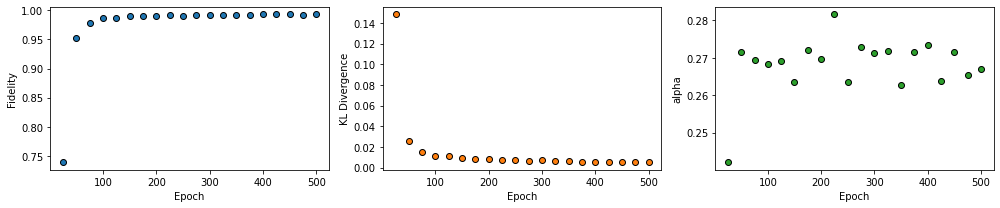

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 3))
ax = axs[0]
ax.plot(epoch, fidelities, "o", color="C0", markeredgecolor="black")
ax.set_ylabel(r"Fidelity")
ax.set_xlabel(r"Epoch")

ax = axs[1]
ax.plot(epoch, KLs, "o", color="C1", markeredgecolor="black")
ax.set_ylabel(r"KL Divergence")
ax.set_xlabel(r"Epoch")

ax = axs[2]
ax.plot(epoch, coeffs, "o", color="C2", markeredgecolor="black")
ax.set_ylabel(r"alpha")
ax.set_xlabel(r"Epoch")

plt.tight_layout()
plt.show()

In [ ]:
nn_state.save("saved_params.pt")